In [229]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from statsmodels.tsa import stattools

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.ndimage.interpolation import shift

# Autocorrelation

In [27]:
def autocorr(x, t=1):
    corr = np.corrcoef(np.array([x[:-t], x[t:]]))
    return corr[1][0]

In [30]:
corr_list = []
df = pd.read_csv('data/2018_1hourdata.csv')
for i in df.columns[1:]:
    corr = autocorr(df[i].values, 24)
    corr_list.append(corr)

In [31]:
df_autocorr = pd.DataFrame(columns=['ids','autocorr'])
df_autocorr['ids'] = df.columns[1:]
df_autocorr['autocorr'] = corr_list
df_autocorr = df_autocorr.sort_values('autocorr', ascending=False)
print(df_autocorr.head(n=20))

              ids  autocorr
71  ALBQ_DENV_out  0.847280
31  EASH_WASH_out  0.824701
78   EASH_ECHI_in  0.822441
39  CHIC_ECHI_out  0.820989
38   CHIC_ECHI_in  0.774371
79  EASH_ECHI_out  0.772015
30   EASH_WASH_in  0.769885
72   AOFA_WASH_in  0.763992
73  AOFA_WASH_out  0.758496
94   ATLA_WASH_in  0.742147
62   AOFA_NEWY_in  0.741030
65  AOFA_STAR_out  0.734446
63  AOFA_NEWY_out  0.733754
64   AOFA_STAR_in  0.732340
2    LOND_NEWY_in  0.731360
12   CHIC_WASH_in  0.730988
93  BOST_NEWY_out  0.723858
8    BOIS_PNWG_in  0.720247
44    BNL_NEWY_in  0.718688
13  CHIC_WASH_out  0.716702


In [ ]:
df_autocorr.to_csv('autocorr_lag24.csv')

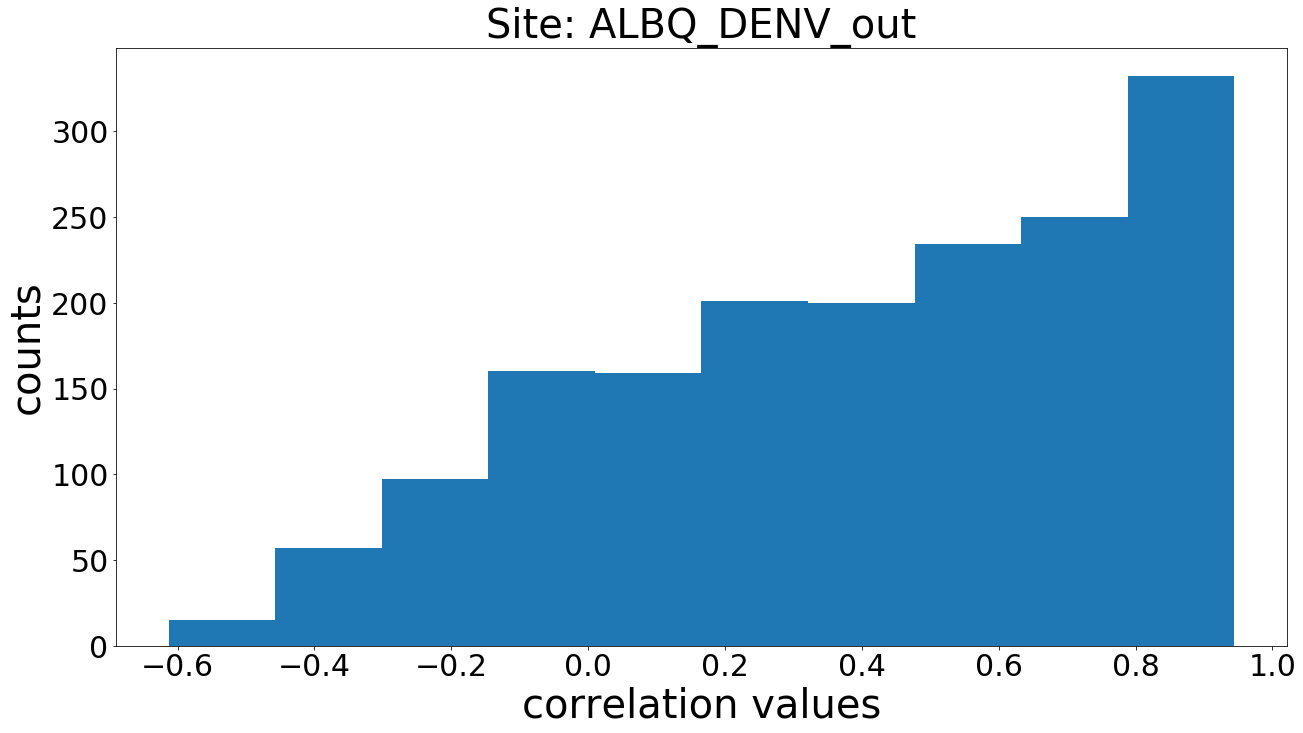

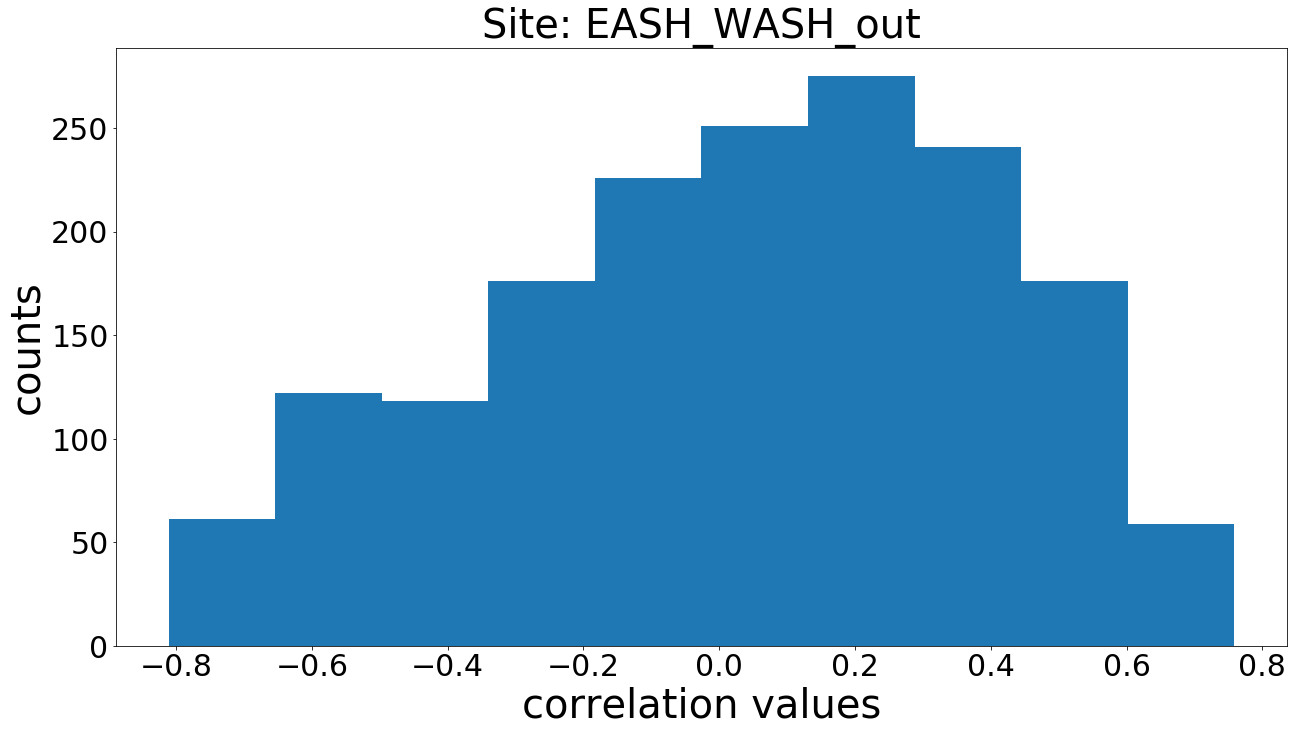

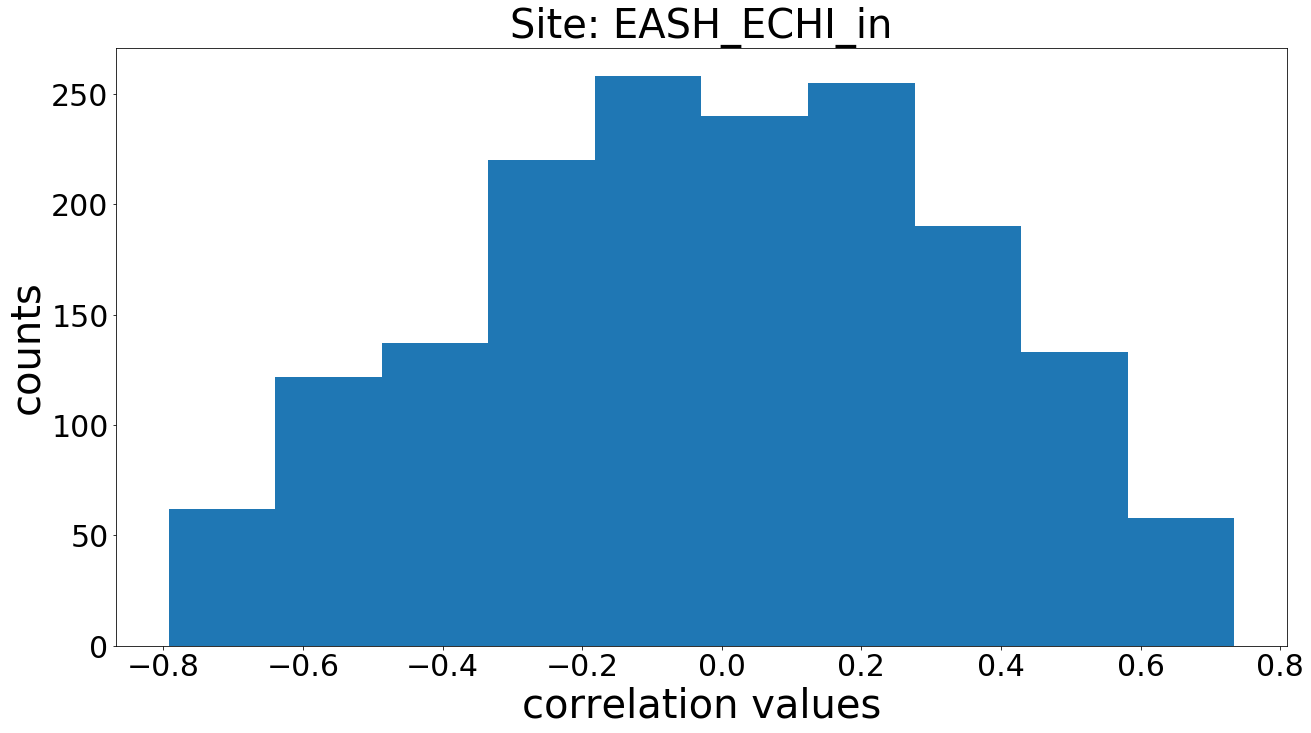

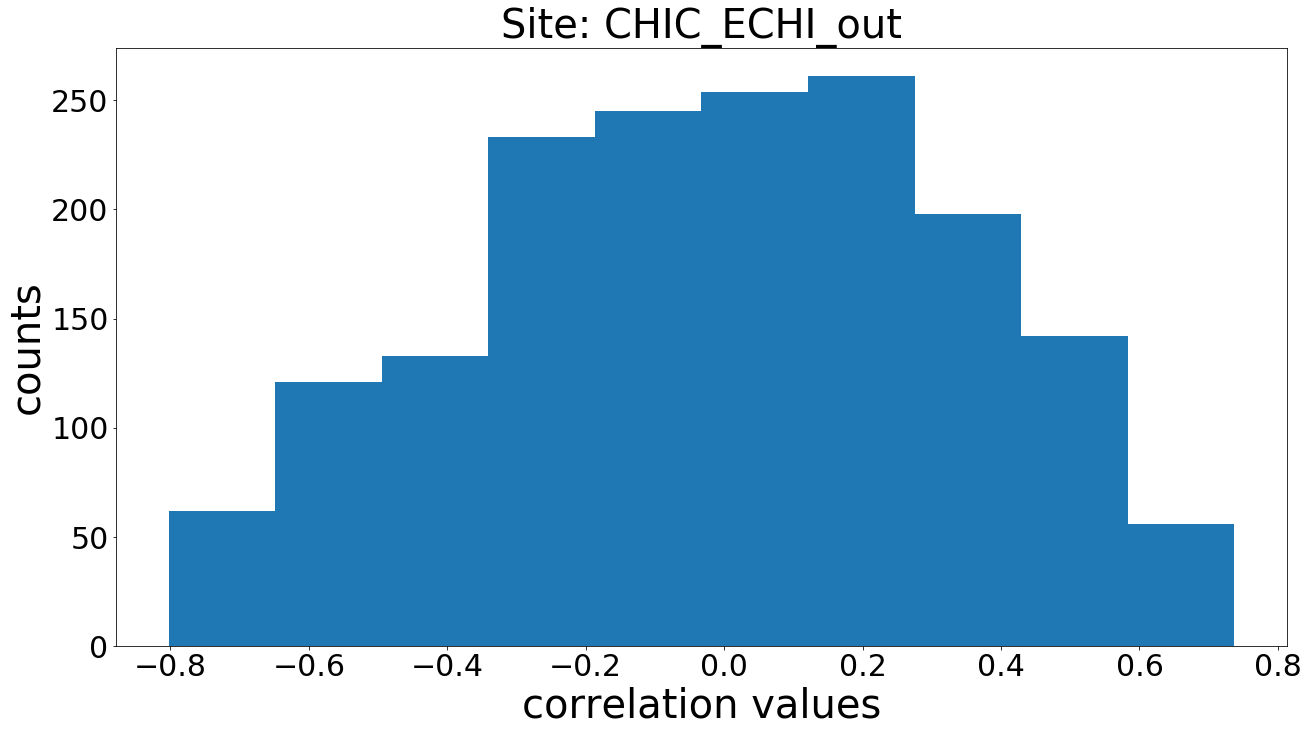

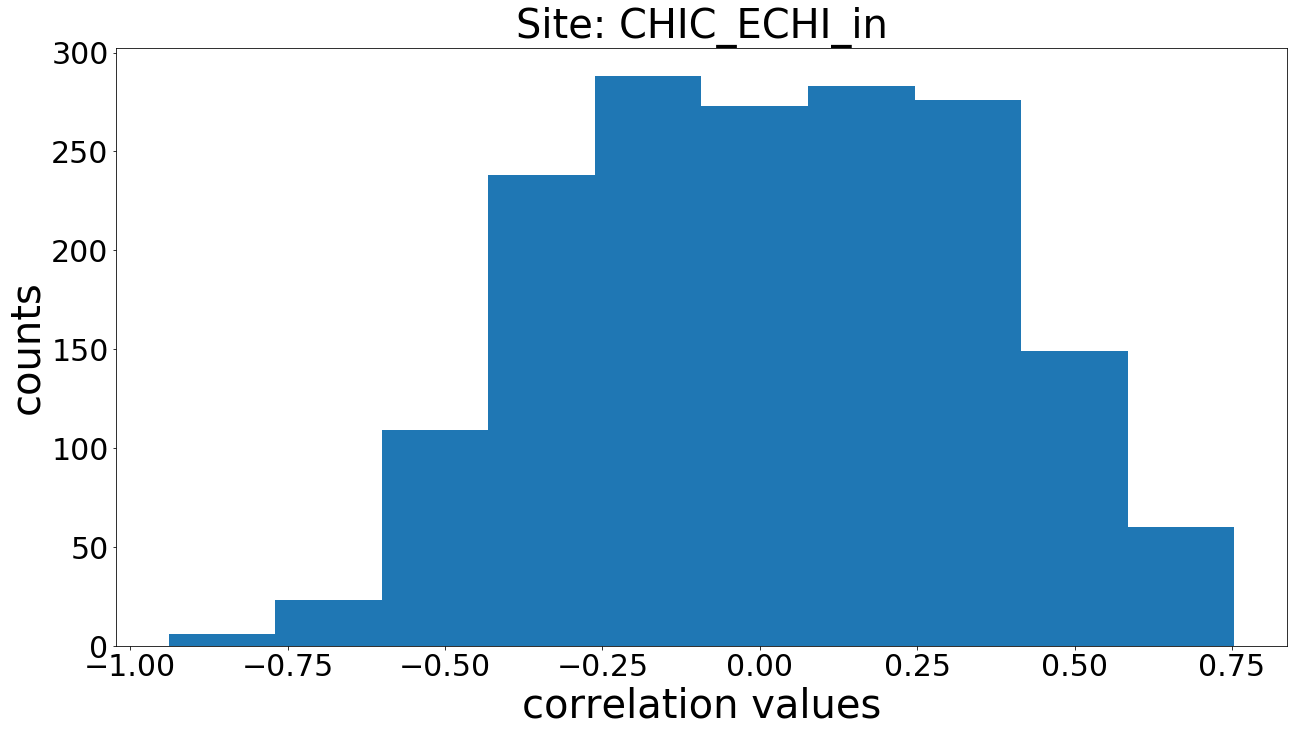

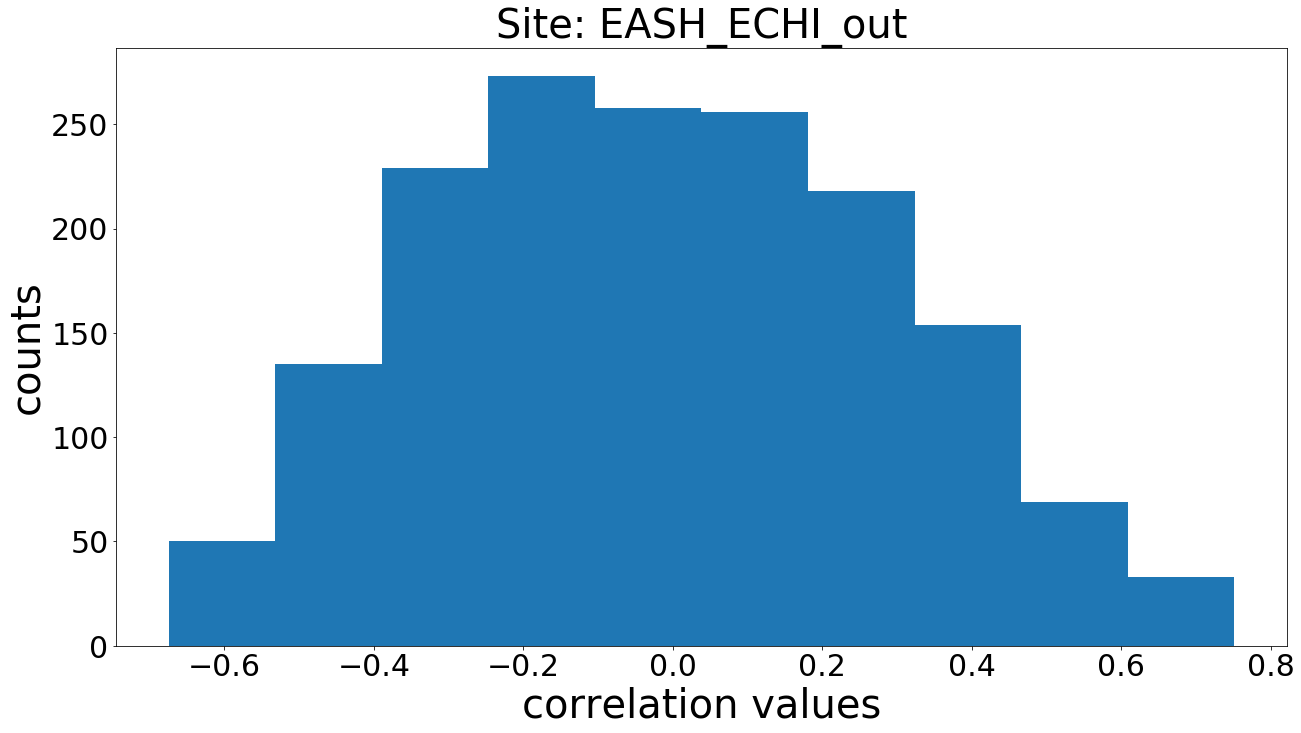

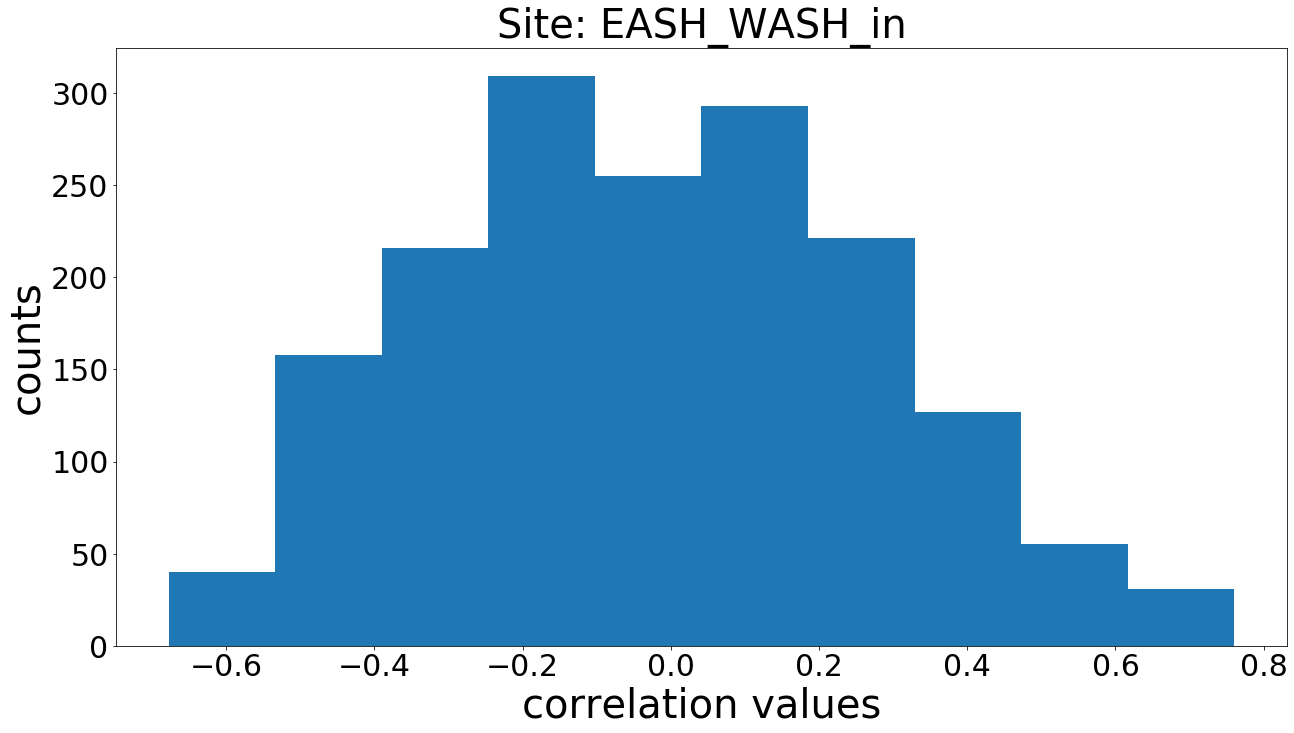

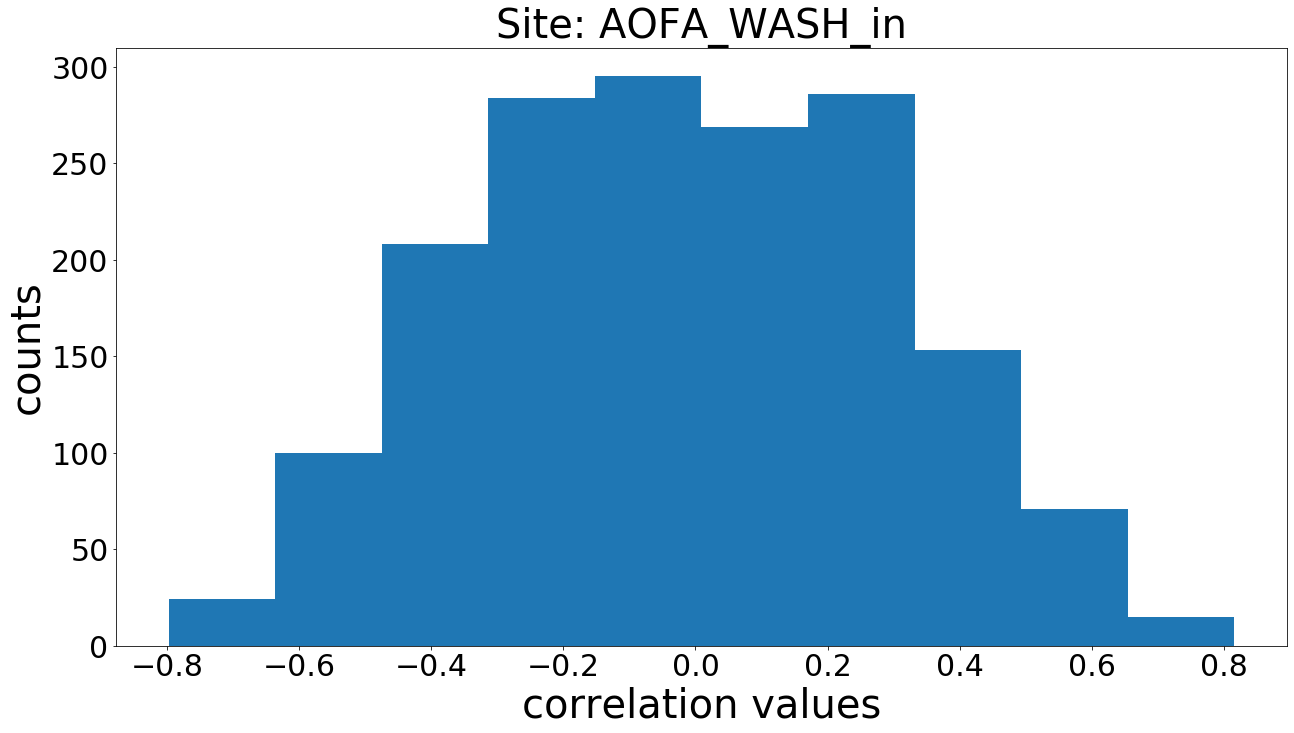

In [224]:
look_back = 24
shift = 1
df = pd.read_csv('data/2018_1hourdata.csv')

for sites in df_autocorr['ids'][0:8]:
    X = df[sites].values

    size = int(len(X) * 0.8)
    train, test = X[0:size], X[size:len(X)]

    #scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
    #train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
    #test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

    x_test, y_test = [], []
    i = 0
    while i + (2* look_back) <= len(test):
        x_i = test[i: i + look_back]
        y_i = test[i + look_back: i + (2* look_back)]
        x_test.append(x_i)
        y_test.append(y_i)
        i = i + 1
    x_test = np.stack(x_test, axis=0)
    y_test = np.stack(y_test, axis=0)
    
    corr_list = []
    for i in range(len(x_test)):
        corr = np.corrcoef(x_test[i],y_test[i])[1,0]
        corr_list.append(corr)
    fig = plt.figure(figsize=(21, 11))
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.hist(corr_list)
    plt.ylabel('counts', fontsize=40)
    plt.xlabel('correlation values', fontsize=40)
    plt.title('Site: '+ sites, fontsize=40)
    plt.show()

# Models

In [236]:
def smooth(x,window_len,window='hanning'):
        if x.ndim != 1:
                raise (ValueError, "smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise (ValueError, "Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

In [237]:
# Random Forest - Smooth window 3

In [238]:
df = pd.read_csv('data/2018_1hourdata.csv')

# Positively correlated points
cols = ['ALBQ_DENV_out']

window_len = 3

cols_df = df[cols]
input_cols = pd.DataFrame(columns=cols_df.columns)

for i in range(len(cols)):
    input_cols.iloc[:,i] = smooth(cols_df.iloc[:,i].values, window_len, window='flat')
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(input_cols.iloc[:,i].values.reshape(-1, 1))
    input_cols.iloc[:,i] = scaler.transform(input_cols.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]


Y = input_cols['ALBQ_DENV_out'].reset_index(drop=True).shift(-1).values

#input_cols = input_cols[cols_input]
size = int(len(Y) * 0.8)

train = input_cols.values[:-1]
test = Y[:-1]
    
ytrain = test[:size]
Xtrain = train[:size, :]

ytest = test[size:-1]
Xtest = train[size:-1, :]

print('Xtrain:', Xtrain.shape, 'ytrain:', ytrain.shape, 'Xtest:', Xtest.shape, 'ytest:', ytest.shape)


Xtrain: (7008, 1) ytrain: (7008,) Xtest: (1750, 1) ytest: (1750,)


In [239]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(Xtrain, ytrain)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [240]:
# Prediction
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred = rf.predict(Xtest)
    ypred_df[i] = shift(ypred, i-1, cval=np.NaN)
    Xtest = ypred[:, None]

Average mae 0.03455507486529413


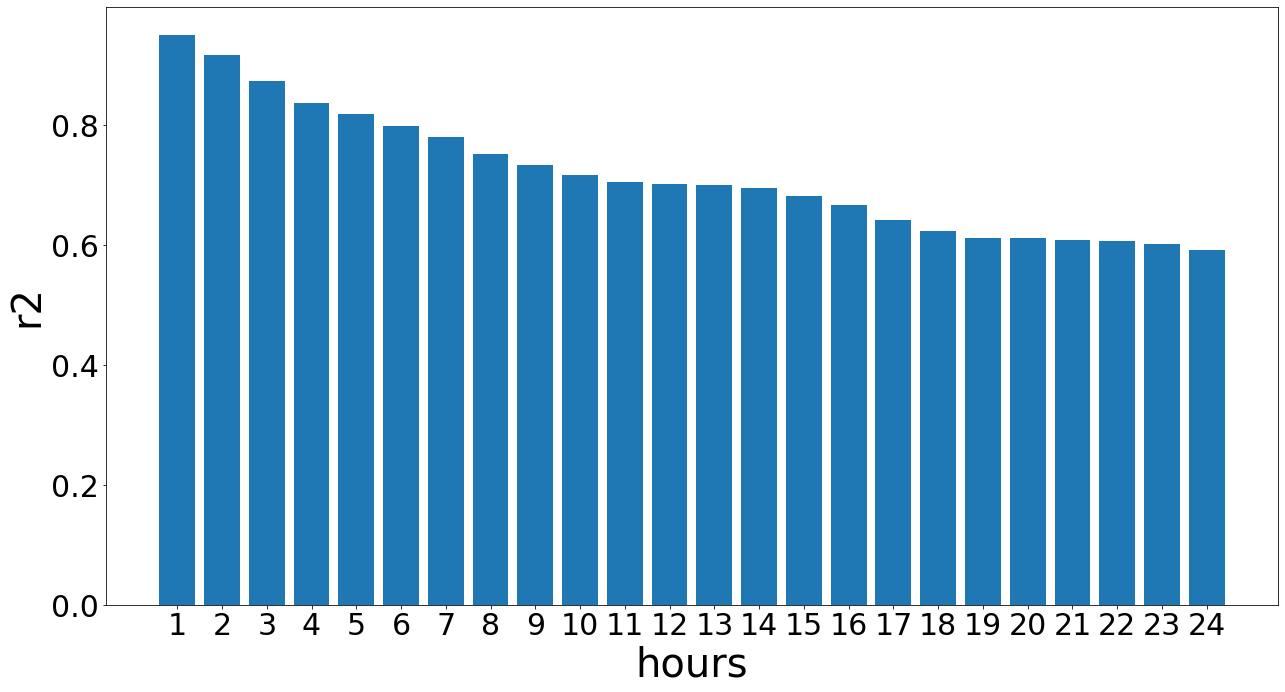

r2 list [0.9491934167873798, 0.9170052877143007, 0.872681192224195, 0.8368107677471428, 0.8182887593042141, 0.7973409915391749, 0.7794302425040074, 0.7521678182897017, 0.7329212250816123, 0.7163283384131973, 0.7045667587456922, 0.7009789465908545, 0.6990623218301542, 0.6952257720379036, 0.6815779170262312, 0.6656630391651326, 0.6417466733252181, 0.6236228003520793, 0.6119634809722738, 0.610781195000517, 0.6072583732154437, 0.6067571627742688, 0.6010569566228081, 0.5918361451527545]


In [241]:
r2_list = []
mae_list = []
rmse_list = []
mse_list = []

for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][i-1:]
    ypred = ypred_df.iloc[:,horizon][i-1:]
    r2_list.append(r2_score(yobs, ypred))
    mae_list.append(mean_absolute_error(yobs, ypred))
print('Average mae', np.mean(mae_list))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()
print('r2 list', r2_list)

In [232]:
# Random Forest - Smooth window 6

In [242]:
df = pd.read_csv('data/2018_1hourdata.csv')

# Positively correlated points
cols = ['ALBQ_DENV_out']

window_len = 6

cols_df = df[cols]
input_cols = pd.DataFrame(columns=cols_df.columns)

for i in range(len(cols)):
    input_cols.iloc[:,i] = smooth(cols_df.iloc[:,i].values, window_len, window='flat')
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(input_cols.iloc[:,i].values.reshape(-1, 1))
    input_cols.iloc[:,i] = scaler.transform(input_cols.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]

Y = input_cols.iloc[:,0].reset_index(drop=True).shift(-1).values

#input_cols = input_cols[cols_input]
size = int(len(Y) * 0.8)

train = input_cols.values[:-1]
test = Y[:-1]
    
ytrain = test[:size]
Xtrain = train[:size, :]

ytest = test[size:-1]
Xtest = train[size:-1, :]

print('Xtrain:', Xtrain.shape, 'ytrain:', ytrain.shape, 'Xtest:', Xtest.shape, 'ytest:', ytest.shape)


Xtrain: (7008, 1) ytrain: (7008,) Xtest: (1750, 1) ytest: (1750,)


In [243]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(Xtrain, ytrain)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Average mae 0.03523597539117769


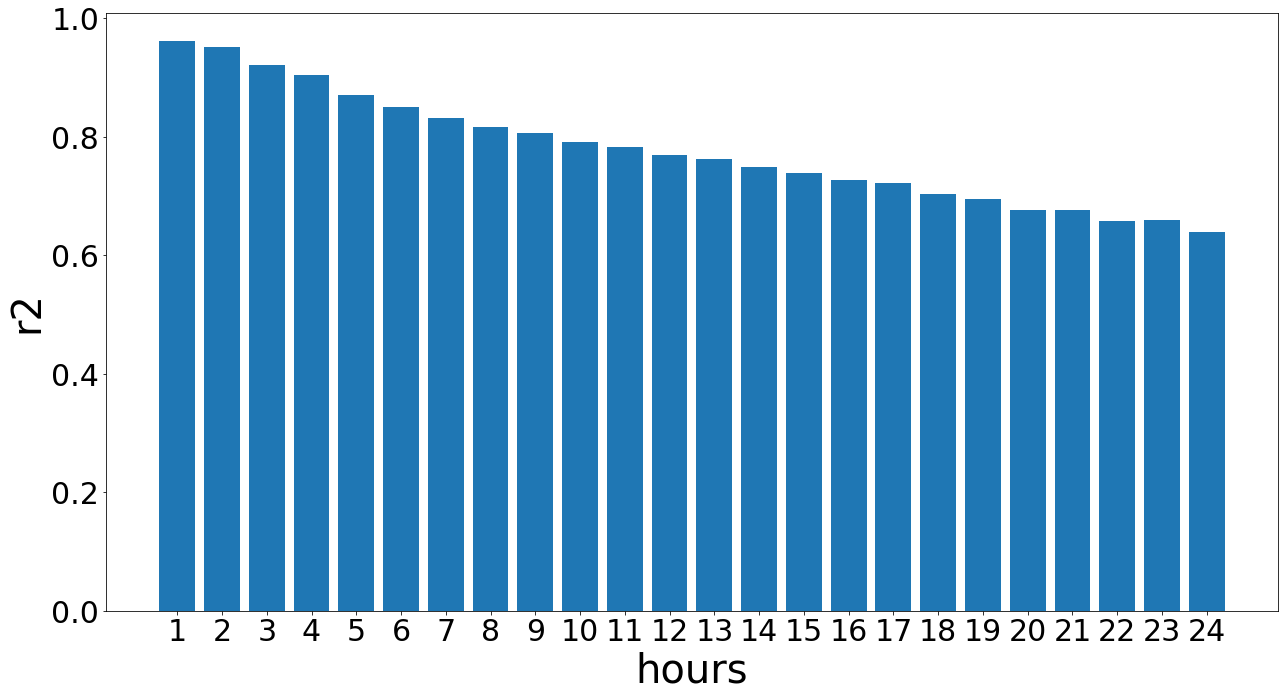

r2 list [0.9607499682075594, 0.9507040919899421, 0.9207026073044011, 0.9035881118649609, 0.8700693739917837, 0.8503558232600646, 0.831845926470953, 0.8160634360662722, 0.8058968366843096, 0.7906116804535238, 0.7823185260411294, 0.7692280582255506, 0.7616960607233962, 0.7482668363446987, 0.739142675297555, 0.7273154016117399, 0.7212068936360609, 0.7034221294671359, 0.6941636038494761, 0.6768880980510718, 0.6758771208402039, 0.6575176239897056, 0.6595612021719764, 0.6382539035544095]


In [244]:
# Prediction
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred = rf.predict(Xtest)
    ypred_df[i] = shift(ypred, i-1, cval=np.NaN)
    Xtest = ypred[:, None]

# Plot
r2_list = []
mae_list = []
rmse_list = []
mse_list = []

for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][i-1:]
    ypred = ypred_df.iloc[:,horizon][i-1:]
    r2_list.append(r2_score(yobs, ypred))
    mae_list.append(mean_absolute_error(yobs, ypred))
print('Average mae', np.mean(mae_list))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()
print('r2 list', r2_list)

In [148]:
# Linear regression - window 3

In [245]:
df = pd.read_csv('data/2018_1hourdata.csv')

# Positively correlated points
cols = ['ALBQ_DENV_out']

window_len = 3

cols_df = df[cols]
input_cols = pd.DataFrame(columns=cols_df.columns)

for i in range(len(cols)):
    input_cols.iloc[:,i] = smooth(cols_df.iloc[:,i].values, window_len, window='flat')
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(input_cols.iloc[:,i].values.reshape(-1, 1))
    input_cols.iloc[:,i] = scaler.transform(input_cols.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]

Y = input_cols.iloc[:,0].reset_index(drop=True).shift(-1).values

#input_cols = input_cols[cols_input]
size = int(len(Y) * 0.8)

train = input_cols.values[:-1]
test = Y[:-1]
    
ytrain = test[:size]
Xtrain = train[:size, :]

ytest = test[size:-1]
Xtest = train[size:-1, :]

print('Xtrain:', Xtrain.shape, 'ytrain:', ytrain.shape, 'Xtest:', Xtest.shape, 'ytest:', ytest.shape)


Xtrain: (7008, 1) ytrain: (7008,) Xtest: (1750, 1) ytest: (1750,)


Average mae 0.031282262735996484


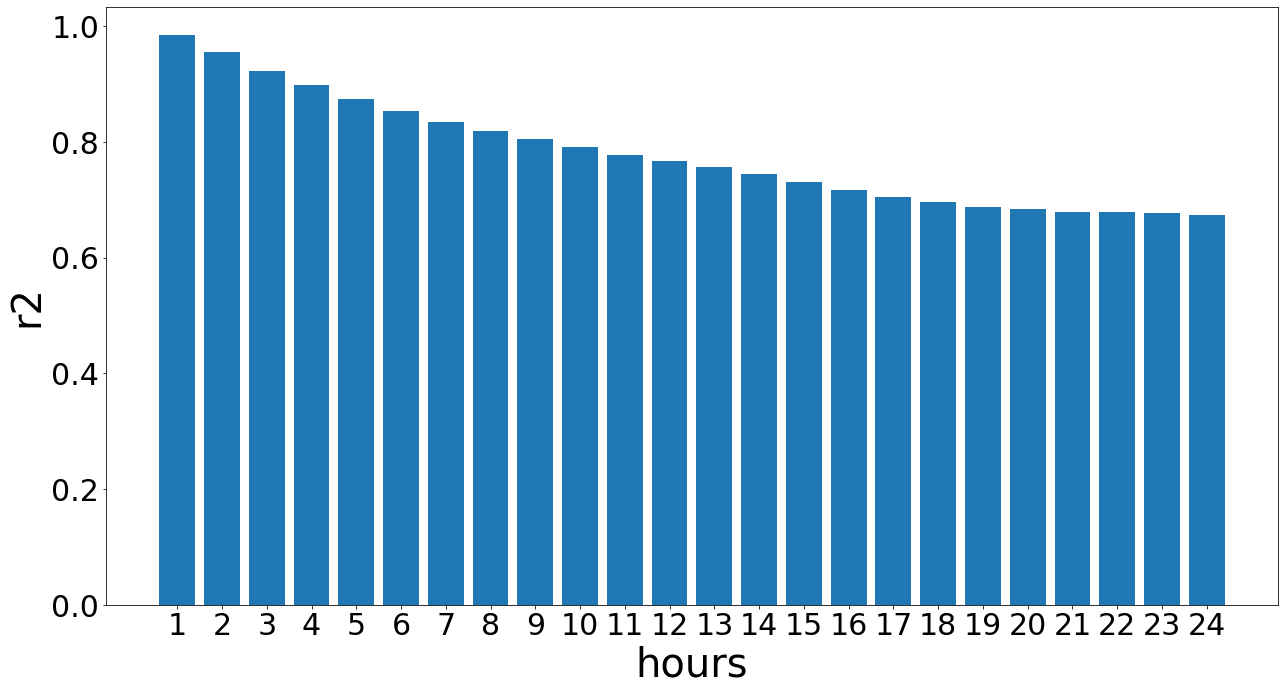

r2 list [0.9840844165520259, 0.9556313895005439, 0.9223143127218645, 0.8975074365480392, 0.8740268539971932, 0.8531570986842155, 0.8349140825067254, 0.8195301339803996, 0.8053565107846163, 0.7908418404514226, 0.7777645091440146, 0.7661159901815107, 0.7561566812324416, 0.7444625689029671, 0.731073257311196, 0.7168327574462718, 0.7047632461625017, 0.6955888305824514, 0.6882398068886482, 0.6830889126524597, 0.6792209352576031, 0.6784757766863516, 0.6766333489378983, 0.673533538904311]


In [246]:
# Import the model we are using
from sklearn import datasets, linear_model
lr = linear_model.LinearRegression()
lr.fit(Xtrain, ytrain)

# Prediction
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred = lr.predict(Xtest)
    ypred_df[i] = shift(ypred, i-1, cval=np.NaN)
    Xtest = ypred[:, None]

# Plot
r2_list = []
mae_list = []
rmse_list = []
mse_list = []

for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][i-1:]
    ypred = ypred_df.iloc[:,horizon][i-1:]
    r2_list.append(r2_score(yobs, ypred))
    mae_list.append(mean_absolute_error(yobs, ypred))
print('Average mae', np.mean(mae_list))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()
print('r2 list', r2_list)

In [155]:
# Linear regression - window 6

In [247]:
df = pd.read_csv('data/2018_1hourdata.csv')

# Positively correlated points
cols = ['ALBQ_DENV_out']

window_len = 6

cols_df = df[cols]
input_cols = pd.DataFrame(columns=cols_df.columns)

for i in range(len(cols)):
    input_cols.iloc[:,i] = smooth(cols_df.iloc[:,i].values, window_len, window='flat')
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(input_cols.iloc[:,i].values.reshape(-1, 1))
    input_cols.iloc[:,i] = scaler.transform(input_cols.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]

Y = input_cols.iloc[:,0].reset_index(drop=True).shift(-1).values

#input_cols = input_cols[cols_input]
size = int(len(Y) * 0.8)

train = input_cols.values[:-1]
test = Y[:-1]
    
ytrain = test[:size]
Xtrain = train[:size, :]

ytest = test[size:-1]
Xtest = train[size:-1, :]

print('Xtrain:', Xtrain.shape, 'ytrain:', ytrain.shape, 'Xtest:', Xtest.shape, 'ytest:', ytest.shape)


Xtrain: (7008, 1) ytrain: (7008,) Xtest: (1750, 1) ytest: (1750,)


Average mae 0.028751730098405547


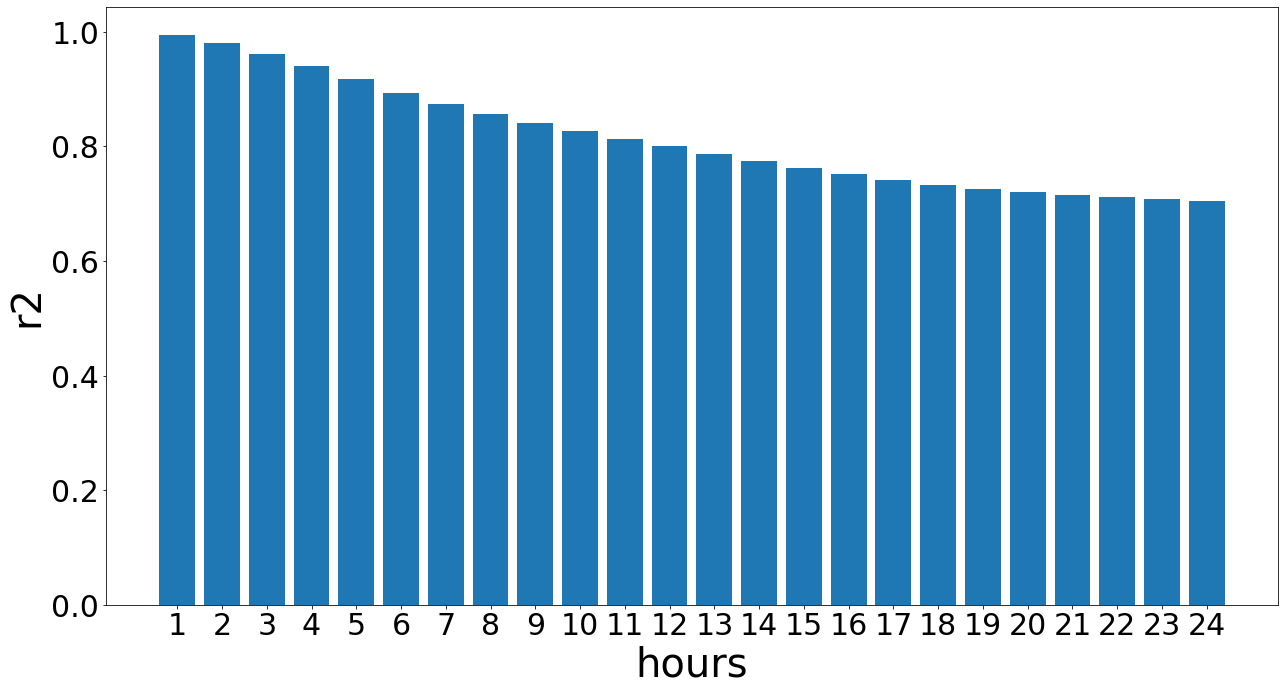

r2 list [0.9940406568734108, 0.9806243481506132, 0.9620654855521416, 0.9404556072341743, 0.9170610547868788, 0.8940697612532588, 0.8744927726988521, 0.8571185622044947, 0.8414328668972546, 0.8267058806540969, 0.8130266858169407, 0.7999841287297106, 0.7875370079604014, 0.7751491831831391, 0.7630529809509798, 0.7514679450211494, 0.7412069404118249, 0.7324369789008617, 0.7253382169881404, 0.7197806859203715, 0.7153936126920538, 0.7120869756297407, 0.7087379304614542, 0.7049895709893839]


In [248]:
# Import the model we are using
from sklearn import datasets, linear_model
lr = linear_model.LinearRegression()
lr.fit(Xtrain, ytrain)

# Prediction
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred = lr.predict(Xtest)
    ypred_df[i] = shift(ypred, i-1, cval=np.NaN)
    Xtest = ypred[:, None]

# Plot
r2_list = []
mae_list = []
rmse_list = []
mse_list = []

for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][i-1:]
    ypred = ypred_df.iloc[:,horizon][i-1:]
    r2_list.append(r2_score(yobs, ypred))
    mae_list.append(mean_absolute_error(yobs, ypred))
print('Average mae', np.mean(mae_list))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()
print('r2 list', r2_list)

In [ ]:
# Gradient Boosting regression - window 3

In [249]:
df = pd.read_csv('data/2018_1hourdata.csv')

# Positively correlated points
cols = ['ALBQ_DENV_out']

window_len = 3

cols_df = df[cols]
input_cols = pd.DataFrame(columns=cols_df.columns)

for i in range(len(cols)):
    input_cols.iloc[:,i] = smooth(cols_df.iloc[:,i].values, window_len, window='flat')
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(input_cols.iloc[:,i].values.reshape(-1, 1))
    input_cols.iloc[:,i] = scaler.transform(input_cols.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]

Y = input_cols.iloc[:,0].reset_index(drop=True).shift(-1).values

#input_cols = input_cols[cols_input]
size = int(len(Y) * 0.8)

train = input_cols.values[:-1]
test = Y[:-1]
    
ytrain = test[:size]
Xtrain = train[:size, :]

ytest = test[size:-1]
Xtest = train[size:-1, :]

print('Xtrain:', Xtrain.shape, 'ytrain:', ytrain.shape, 'Xtest:', Xtest.shape, 'ytest:', ytest.shape)


Xtrain: (7008, 1) ytrain: (7008,) Xtest: (1750, 1) ytest: (1750,)


Average mae 0.031166228759691206


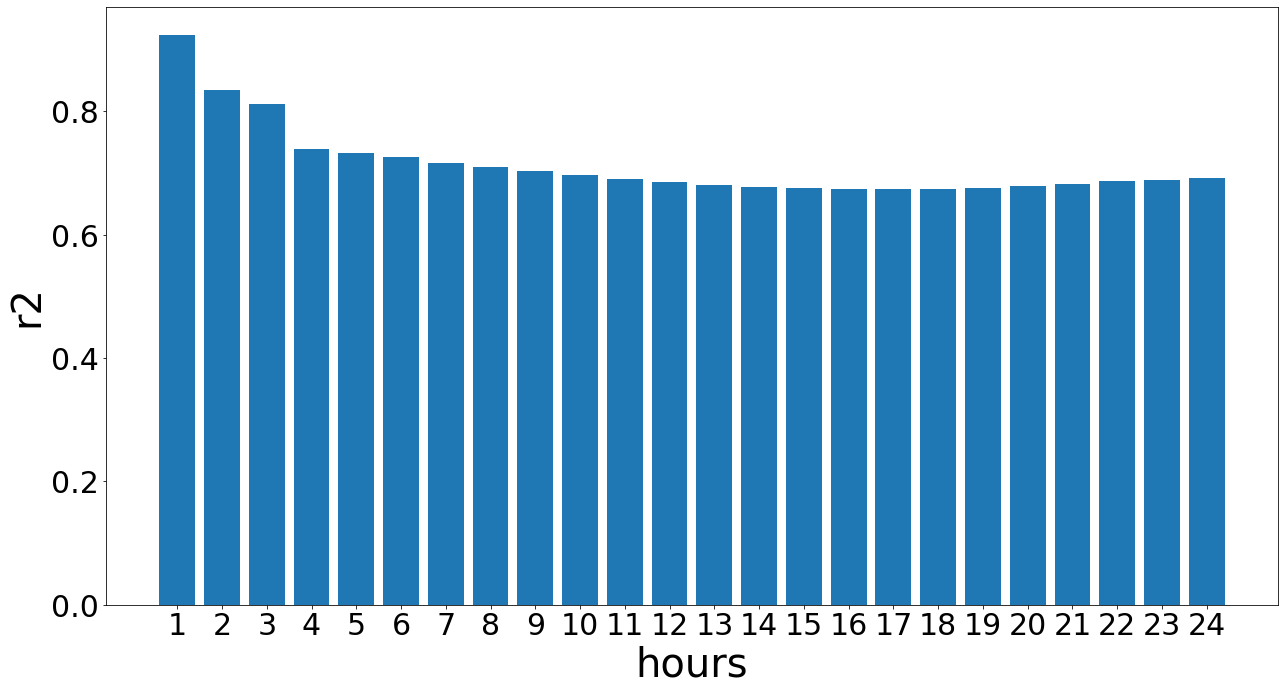

r2 list [0.9235219195329399, 0.8341676163206972, 0.8128318998617069, 0.7389632813885239, 0.7320424265203642, 0.7263408329848617, 0.7162599223732085, 0.7095174541217184, 0.7029838087143778, 0.6962147357824073, 0.6911749853225836, 0.6858097461077466, 0.6808725219700449, 0.6772952790696387, 0.675774297373047, 0.6750505321513482, 0.6735541675995533, 0.6739152312196794, 0.6754713854640002, 0.6795312236914461, 0.6821360994531918, 0.6867103548501152, 0.6893082223642613, 0.6919431759690062]


In [250]:
# Import the model we are using
from sklearn import ensemble
lr = ensemble.GradientBoostingRegressor()
lr.fit(Xtrain, ytrain)

# Prediction
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred = lr.predict(Xtest)
    ypred_df[i] = shift(ypred, i-1, cval=np.NaN)
    Xtest = ypred[:, None]

# Plot
r2_list = []
mae_list = []
rmse_list = []
mse_list = []

for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][i-1:]
    ypred = ypred_df.iloc[:,horizon][i-1:]
    r2_list.append(r2_score(yobs, ypred))
    mae_list.append(mean_absolute_error(yobs, ypred))
print('Average mae', np.mean(mae_list))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()
print('r2 list', r2_list)

In [169]:
# Gradient Boosting regression - window 6

In [251]:
df = pd.read_csv('data/2018_1hourdata.csv')

# Positively correlated points
cols = ['ALBQ_DENV_out']

window_len = 6

cols_df = df[cols]
input_cols = pd.DataFrame(columns=cols_df.columns)

for i in range(len(cols)):
    input_cols.iloc[:,i] = smooth(cols_df.iloc[:,i].values, window_len, window='flat')
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(input_cols.iloc[:,i].values.reshape(-1, 1))
    input_cols.iloc[:,i] = scaler.transform(input_cols.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]

Y = input_cols.iloc[:,0].reset_index(drop=True).shift(-1).values

#input_cols = input_cols[cols_input]
size = int(len(Y) * 0.8)

train = input_cols.values[:-1]
test = Y[:-1]
    
ytrain = test[:size]
Xtrain = train[:size, :]

ytest = test[size:-1]
Xtest = train[size:-1, :]

print('Xtrain:', Xtrain.shape, 'ytrain:', ytrain.shape, 'Xtest:', Xtest.shape, 'ytest:', ytest.shape)


Xtrain: (7008, 1) ytrain: (7008,) Xtest: (1750, 1) ytest: (1750,)


Average mae 0.028528928435029122


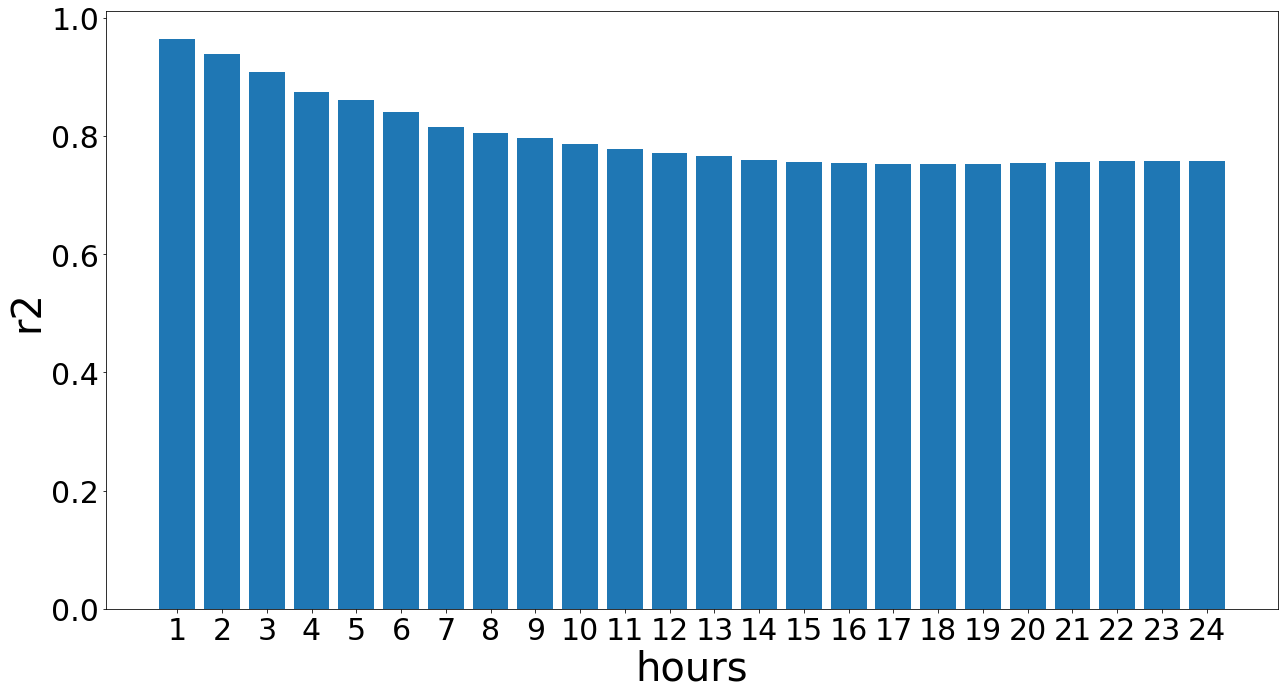

r2 list [0.9634795006844816, 0.9379229019318824, 0.9083021606121107, 0.8735597394552149, 0.8612499254355808, 0.8397623817014336, 0.815547341060857, 0.8052222590575868, 0.7961679718672859, 0.7864344559656731, 0.7784452973088518, 0.7713099427959396, 0.7654823839369894, 0.7597345926609553, 0.7559384963463627, 0.7536878060964637, 0.752195102886119, 0.7519190164947098, 0.7526417128615644, 0.7543635217474018, 0.7558891362930334, 0.7572123121747452, 0.7577974489682873, 0.7576971229134605]


In [252]:
# Import the model we are using
from sklearn import ensemble
lr = ensemble.GradientBoostingRegressor()
lr.fit(Xtrain, ytrain)

# Prediction
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred = lr.predict(Xtest)
    ypred_df[i] = shift(ypred, i-1, cval=np.NaN)
    Xtest = ypred[:, None]

# Plot
r2_list = []
mae_list = []
rmse_list = []
mse_list = []

for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][i-1:]
    ypred = ypred_df.iloc[:,horizon][i-1:]
    r2_list.append(r2_score(yobs, ypred))
    mae_list.append(mean_absolute_error(yobs, ypred))
print('Average mae', np.mean(mae_list))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()
print('r2 list', r2_list)